In [1]:
from gurobipy import *
import matplotlib.pyplot as plt
%matplotlib inline

## 模型导入与求解

In [2]:
model = read('facility_p1.lp')
model.optimize()

Optimize a model with 9 rows, 25 columns and 45 nonzeros
Variable types: 20 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+03, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 2e+01]
Presolve time: 0.00s
Presolved: 9 rows, 25 columns, 45 nonzeros
Variable types: 20 continuous, 5 integer (5 binary)

Root relaxation: objective 1.998333e+05, 11 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 199833.333    0    1          - 199833.333      -     -    0s
H    0     0                    210500.00000 199833.333  5.07%     -    0s
     0     0 210252.941    0    2 210500.000 210252.941  0.12%     -    0s

Cutting planes:
  Gomory: 1

Explored 0 nodes (13 simplex iterations) in 0.05 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 210500 
Pool ob

## 结果与变量记录

In [3]:
origObjVal = model.ObjVal
print '模型最优解，最低成本为：%d' % origObjVal

模型最优解，最低成本为：210500


* facility_problem实例中，plant的个数为5，故这里的循环采用range(5)
* GUROBI中的Var对象与结构体类似，因此可直接通过.+name获取信息，也可随时针对变量存储一些临时信息，自定义信息一般在name前加下划线，这里通过'_origX'存储origin model中open的最优值

In [4]:
open = dict()
print '原模型的最优值：'
for plant in range(5):
    open[plant] = model.getVarByName('open[%d]' % plant)
    open[plant]._origX = open[plant].X
    print 'plant-%d:%d  ' % (plant, open[plant]._origX),

原模型的最优值：
plant-0:1   plant-1:1   plant-2:0   plant-3:1   plant-4:1  


# 分析过程
* 将原始模型最优解中open的值修改，观察最优值（总成本的变化）
* 因open为0-1变量，故修改操作为(1-open.origin_value)

* 关闭GUROBI的输出，GUROBI运行文件时，会将所有信息保存到gurobi.log文件中（默认保存路径为当前文件），可自行去查看

In [5]:
model.setParam('OutputFlag', 0)

* GUROBI对变量参数的改变具有滞后性，即改变的生效是在下一次调用model.optimize()或者model.update()
* 每次分析完open对目标的灵敏度后，切记还原改变，否则下次改变其他open[plant]参数时，上次改变也会保留，达不到控制变量的效果

In [6]:
sensitivities = []
for plant in range(5):
    if(open[plant]._origX < 0.5):
        open[plant].LB = open[plant].start = 1
    else:
        open[plant].UB = open[plant].start = 0
        
    for plant_temp in range(5):
        if(plant == plant_temp):
            continue
        open[plant_temp].start = open[plant_temp]._origX
    
    # 开始优化
    model.optimize()
    print '将plant-%d的值从%d变为%d后，模型最优解为：%d，目标灵敏度为：%d' % \
            (plant, open[plant]._origX, (1 - open[plant]._origX), model.ObjVal, (model.ObjVal - origObjVal))
    sensitivities.append(model.ObjVal - origObjVal)
    
    # 还原对变量的改变
    open[plant].LB = 0
    open[plant].UB = 1

将plant-0的值从1变为0后，模型最优解为：238400，目标灵敏度为：27900
将plant-1的值从1变为0后，模型最优解为：229600，目标灵敏度为：19100
将plant-2的值从0变为1后，模型最优解为：210900，目标灵敏度为：400
将plant-3的值从1变为0后，模型最优解为：219800，目标灵敏度为：9300
将plant-4的值从1变为0后，模型最优解为：210900，目标灵敏度为：400


# 结果展示

In [7]:
plants_temp = [i for i, v in enumerate(sensitivities) if v == min(sensitivities)]
print '对目标的灵敏度最低的plant：%s' % plants_temp

对目标的灵敏度最低的plant：[2, 4]


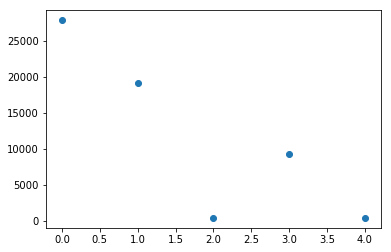

In [8]:
plt.scatter(range(5) ,sensitivities)